In [126]:
# imports
%load_ext autoreload
%autoreload 2
import torch
from mpl_toolkits.axes_grid1 import AxesGrid
import orqviz
import numpy as np
import scipy as sp
from classic_training import cost_func
from data import *
from generate_experiments import get_qnn
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import matplotlib
import matplotlib as mpl
import qnns.cuda_qnn as cuda_qnn
from utils import *
from matplotlib import cm

In [127]:
# gen datapoints
def generate_random_datapoints(numb_points, s_rank, U):
    schmidt_rank = s_rank
    num_points = numb_points
    x_qbits = 1
    r_qbits = s_rank - x_qbits
    inputs = torch.from_numpy(
        np.array(uniform_random_data(schmidt_rank, num_points, x_qbits, r_qbits))
    )
    inputs = inputs.reshape(
        (inputs.shape[0], int(inputs.shape[1] / U.shape[0]), U.shape[0])
    ).permute(0, 2, 1)
    return inputs

In [128]:
# get zero/one datapoints
def get_zero_one_datapoints():
    zero_state = np.array([[1],[0]], dtype=complex)
    one_state = np.array([[0],[1]], dtype=complex)
    super_pos_state = np.array([[1],[1]], dtype=complex)/np.sqrt(2)
    tensor = torch.tensor([zero_state, one_state])
    return tensor
    # inputs = torch.from_numpy(np.array([zero_state, one_state], dtype=complex))
    # print(inputs.size())
    # inputs = inputs.reshape((inputs.shape[0], int(inputs.shape[1] / U.shape[0]), U.shape[0])).permute(0, 2, 1)
    # return inputs

In [129]:
# gen 2D loss landscape
def generate_loss_landscape(grid_size, inputs, U, qnn):
    landscape = []
    lanscape_limit = 2 * math.pi
    step_size = lanscape_limit / grid_size
    x = inputs
    expected_output = torch.matmul(U, x)
    y_true = expected_output.conj()
    for i in range(grid_size):
        # start at 2pi so y axis label still fits (upwards scaling instead of downards)
        arg_1 = lanscape_limit - i * step_size
        row = []
        for j in range(grid_size):
            # start at 0 because x axis label direction is correct
            arg_2 = j * step_size
            qnn.params = torch.tensor([[[arg_1, arg_2]]], dtype=torch.float64, requires_grad=True)
            cost = cost_func(inputs, y_true, qnn, device="cpu")
            row.append(cost.item())
        landscape.append(row)
    return landscape

In [130]:
# gen 3D loss landscape for U3
def generate_3D_loss_landscape_with_labels(grid_size, inputs, U):
    qnn = get_qnn("CudaPennylane", list(range(1)), 1, device="cpu")
    landscape = []
    x_array =[]
    y_array = []
    z_array = []
    points = []
    lanscape_limit = 2 * math.pi
    step_size = lanscape_limit / grid_size
    x = inputs
    expected_output = torch.matmul(U, x)
    y_true = expected_output.conj()
    for i in range(grid_size):
        # start at 2pi so y axis label still fits (upwards scaling instead of downards)
        arg_1 = i * step_size
        for j in range(grid_size):
            # start at 0 because x axis label direction is correct
            arg_2 = lanscape_limit-j * step_size
            for k in range(grid_size):
                # maybe change direction?
                arg_3 = k * step_size
                qnn.params = torch.tensor([[[arg_1, arg_2, arg_3]]], dtype=torch.float64, requires_grad=True)
                cost = cost_func(inputs, y_true, qnn, device="cpu")
                landscape.append(cost.item())
                x_array.append(arg_3)
                y_array.append(arg_2)
                z_array.append(arg_1)
    points.append(x_array)
    points.append(y_array)
    points.append(z_array)
    return landscape, points

In [131]:
# get plot metadata for different modes
def get_meta_for_mode(mode, data, min_val, max_val,titles,o, gate_name, ansatz):
    low_threshold= 0.000000001
    if mode =="default":
        c_map ="plasma"
        sup_title= f"Loss Landscapes for {ansatz}($\\phi,\\lambda)$ Approximating {gate_name} for Different Datasets"
        title=titles[o]
        v_min = min(min_val, 0)
        v_max = max(max_val,1)
    elif mode == "grad":
        c_map ="winter"
        sup_title= "Gradient Magnitudes"
        # average gradient magnitude adjusted for sample frequency - not sure how to call this.
        title= f"GM Score: {np.round(np.average(data)*len(data), 2)}"
        v_min = min(min_val, 0)
        v_max = math.ceil(max_val * 100.0) / 100.0
    elif mode == "log_scale":
        v_max = 1
        #v_min = min((min_val+low_threshold/18)*12, low_threshold)
        v_min = low_threshold
        c_map ="Greys"
        if min_val < low_threshold:
            min_text="< 0.000000001"
        else:
            min_text=f"= {np.round(min_val, 10)}"        
        sup_title= f"Logarithmic Loss (min. {min_text})"
        title= titles[o]
    return c_map, sup_title, title, v_min, v_max

In [132]:
# plot a row of datasets
def plot_row(in_data,titles, gate_name, ansatz, mode="default"):    
    in_data
    width = len(in_data)        
    min_val = np.min(in_data)
    max_val = np.max(in_data)
    fig, ax = plt.subplots(1, width, figsize=(9,3))
    for data_idx in range(width):        
        data = in_data[data_idx]
        # get mode dependent settings such as titles, color maps, thresholds, etc.
        c_map, sup_title, title, v_min, v_max = get_meta_for_mode(mode, data, min_val, max_val, titles, data_idx, gate_name, ansatz)
        length = len(data)
        x_labels = []
        # create labels
        for i in range(length):
            n = f"{np.round(i*2/length, 1)} $\\pi$"
            x_labels.append(n)
        y_labels = reversed(x_labels)
        # do plot stuff
        # for logarithmic scale
        if mode == "log_scale":
            data = data + v_min
            im = ax[data_idx].imshow(data, cmap = c_map,norm=matplotlib.colors.LogNorm(vmin=v_min, vmax=v_max))
        else:
        # normal scale
            im = ax[data_idx].imshow(data, cmap = c_map,vmin=v_min, vmax=v_max)
        # what happens to values below the color bar (=legend) threshold
        cm_copy= im.cmap.copy()
        cm_copy.set_under("r", 1)
        im.cmap = cm_copy
        # set label ticks
        ax[data_idx].set_xticks(np.arange(len(x_labels)), labels=x_labels)
        ax[data_idx].set_yticks(np.arange(len(x_labels)), labels=y_labels)
        ax[data_idx].set_ylabel("$\\phi$", rotation= 180, va="center")
        ax[data_idx].set_xlabel("$\\lambda$")
        tick_density = int(length / 4)
        # only display every x'th tick
        ax[data_idx].set_xticks(ax[data_idx].get_xticks()[::tick_density])
        ax[data_idx].set_yticks(ax[data_idx].get_yticks()[::tick_density])
        plt.setp(ax[data_idx].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        ax[data_idx].set_title(title)
    fig.colorbar(im, ax=ax.ravel().tolist(), shrink=0.58)
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.75, 
                    top=0.9, 
                    wspace=0.7)
    fig.suptitle(sup_title, x=0.43)
    plt.show()

In [133]:
# 3D scatter plot of U3 Gate
def plot_scatter_of_U3(landscape, points, ticks):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')    
    v_min = 0.000000001
    v_max = 1
    values = np.array(landscape)+v_min
    # the higher v_min, the more similar entangled and non entangled sample minima look


    x = points[0]
    y = points[1]
    z = points[2]
    c_white = matplotlib.colors.colorConverter.to_rgba('white',alpha = 0)
    c_red= matplotlib.colors.colorConverter.to_rgba('red',alpha = 1)
    cmap_rb = matplotlib.colors.LinearSegmentedColormap.from_list('rb_cmap',[c_red,c_white],512)

    im = ax.scatter(x,y,z, c=values, cmap = cmap_rb,norm=matplotlib.colors.LogNorm(vmin=v_min,vmax=v_max)
, depthshade=0)
    # set labels
    length = 6
    x_labels = []
    # create labels
    for i in range(length+1):
        n = f"{np.round(i*2/length,1)} $\\pi$"
        x_labels.append(n)
    x_labels = x_labels
    y_labels = x_labels
    z_labels = x_labels # just for fun
    # set label ticks
    #labels not really working
    tick_density = int(length / 5)
    ax.set_xticks(np.arange(len(x_labels)), labels=x_labels)
    ax.set_yticks(np.arange(len(x_labels)), labels=y_labels)
    ax.set_zticks(np.arange(len(x_labels)), labels=z_labels)
    # ax.set_xticks(ax.get_xticks()[::tick_density])
    # ax.set_yticks(ax.get_yticks()[::tick_density])
    # ax.set_zticks(ax.get_zticks()[::tick_density])
    ax.set_ylabel("$\\phi$", rotation= 180, va="center")
    ax.set_xlabel("$\\lambda$")
    ax.set_zlabel("der andere parameter")
    # only display every x'th tick

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    ax.set_title(f"U3 Minima for (finish title later)")
    # set colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Loss", rotation=-90, va="bottom")
    plt.show()

In [134]:
# plot 3D loss landscape
# https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html
def plot_3d_loss_landscape(landscape, ansatz,title):
    ls = np.array(landscape)
    min_val = np.min(ls)
    max_val = np.max(ls)
    length = len(ls)
    x_labels = []
    # create labels
    for i in range(length):
        n = f"{np.round(i*2/length,1)} $\\pi$"
        x_labels.append(n)
    y_labels = reversed(x_labels)
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    #im = ax.imshow(ls, cmap = "plasma",vmin=min(min_val, 0), vmax=max(max_val,1))
    X = np.arange(0, length,1)
    Y = np.arange(0, length,1)
    X, Y = np.meshgrid(X, Y)
    im = ax.plot_surface(X,Y,ls, cmap = "plasma",vmin=min(min_val, 0), vmax=max(max_val,1))
    # set label ticks
    ax.set_xticks(np.arange(len(x_labels)), labels=x_labels)
    ax.set_yticks(np.arange(len(x_labels)), labels=y_labels)
    ax.set_ylabel("$\\phi$", rotation= 180, va="center")
    ax.set_xlabel("$\\lambda$")
    ax.set_zlabel("Loss")
    tick_density = int(length / 10)
    # only display every x'th tick
    ax.set_xticks(ax.get_xticks()[::tick_density])
    ax.set_yticks(ax.get_yticks()[::tick_density])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Loss", rotation=-90, va="bottom")
    ax.set_title(f"{ansatz}($\\phi,\\lambda)$ Approximating {title}")
    plt.show()

In [135]:
# get grad curvature
def get_grad_curv(landscape):
    first_order_gradients = np.gradient(np.array(landscape))
    second_order_gradients = []
    for grad in first_order_gradients:
        grads_of_grad = np.gradient(np.array(grad))
        for sec_grad in grads_of_grad:
            second_order_gradients.append(sec_grad)
    magnitude_sum = 0
    for g in second_order_gradients:
        magnitude_sum += g**2
    curv_mag = np.sqrt(magnitude_sum)
    return curv_mag

In [136]:
# get scalar curvature
def get_scalar_curvature(landscape):
    grad_xx_xy_yx_yy = []
    scalar_curvature = []
    gradients = np.array(np.gradient(np.array(landscape)))
    # maybe add gradients? not sure
    for gradient in gradients:
        second_grads = np.array(np.gradient(np.array(gradient)))
        for second_grad in second_grads:
            grad_xx_xy_yx_yy.append(second_grad)
    # calculate scalar curvature point by point
    for x_id in range(len(landscape)):
        row = []
        for y_id in range(len(landscape)):
            # hessian for point with entries: [d_xx, d_xy][d_yx, d_yy]
            point_hessian = [[grad_xx_xy_yx_yy[0][x_id][y_id], grad_xx_xy_yx_yy[1][x_id][y_id]],[grad_xx_xy_yx_yy[2][x_id][y_id], grad_xx_xy_yx_yy[3][x_id][y_id]]]
            # gradients as 2 entry vector (x dir, y dir)
            gradient = np.array([gradients[1][x_id][y_id],gradients[0][x_id][y_id]])
            # take euclidean norm
            beta = 1/(1+np.linalg.norm(gradient)**2)
            left_term = beta*(np.trace(point_hessian)**2-np.trace(np.matmul(point_hessian, point_hessian)))
            right_inner = np.matmul(point_hessian, point_hessian)-np.trace(point_hessian)*np.array(point_hessian)
            # order of matmul with gradient does not matter
            right_term= 2*(beta**2)*(np.matmul(np.matmul(gradient.T,right_inner),gradient))
            point_curv = left_term + right_term
            #print(point_curv)
            #maybe sum, maybe not? point curv is 2 entry vector
            row.append(point_curv)
        scalar_curvature.append(row) 
        # output absolute and root to compare visually to grad curvature
    return scalar_curvature

In [137]:
# plot 3D loss landscape with curvature coloring
def plot_3d_loss_landscape_curv(landscape, ansatz, curv_mode = "scalar"):
    landscape = np.array(landscape)
    if curv_mode == "scalar":        
        curv = get_scalar_curvature(landscape)
    elif curv_mode == "grad":
        curv = get_grad_curv(landscape)
    #normalize from -1 to 1
    # max_entry = np.max(np.absolute(curv))
    # curv = curv/max_entry
    min_val = np.min(curv)
    max_val = np.max(curv)
    length = len(curv)
    x_labels = []
    # create labels
    for i in range(length):
        n = f"{np.round(i*2/length,1)} $\\pi$"
        x_labels.append(n)
    y_labels = reversed(x_labels)
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    X = np.arange(0, length,1)
    Y = np.arange(0, length,1)
    X, Y = np.meshgrid(X, Y)
    norm = mpl.colors.Normalize(vmin=min_val, vmax=max_val)
    c_map = mpl.cm.plasma
    im = ax.plot_surface(X,Y,landscape, cmap = c_map, facecolors = c_map(norm(curv)))
    # set label ticks
    ax.set_xticks(np.arange(len(x_labels)), labels=x_labels)
    ax.set_yticks(np.arange(len(x_labels)), labels=y_labels)
    ax.set_ylabel("$\\phi$", rotation= 180, va="center")
    ax.set_xlabel("$\\lambda$")
    ax.set_zlabel("Loss")
    tick_density = int(length / 10)
    # only display every x'th tick
    ax.set_xticks(ax.get_xticks()[::tick_density])
    ax.set_yticks(ax.get_yticks()[::tick_density])
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    #cbar = ax.figure.colorbar(im, ax=ax)
    #cbar.ax.set_ylabel("Loss", rotation=-90, va="bottom")
    m = cm.ScalarMappable(cmap=c_map, norm=norm)
    m.set_array([])
    plt.colorbar(m)
    ax.set_title(f"{ansatz}($\\phi,\\lambda)$ Curvature - {curv_mode} curvature")
    plt.show()

In [138]:
# calculate Total Variation
def calc_total_variation(landscape):
    lanscape_limit = 2 * math.pi
    step_size = lanscape_limit / len(landscape)
    gradients = np.gradient(np.array(landscape))
    total_variation = np.sum(np.absolute(gradients))
    # normalize by adjusting for step size
    normalized_tv = total_variation*step_size
    return np.round(normalized_tv,2)

In [139]:
# calculate IGSD
def calc_IGSD(landscape):
    gradients = np.gradient(np.array(landscape))
    # each array of the gradients encompasses the gradients for one dimension/direction/parameter
    gradient_standard_deviations = []
    for gradient in gradients:
        gradient_standard_deviations.append(np.std(gradient))
    inverse_gradient_standard_deviations= np.divide(1,gradient_standard_deviations)
    return np.round(inverse_gradient_standard_deviations,2)

In [140]:
# multi plot with gradients
def multi_plot_landscape(landscapes, titles, gate_name, ansatz): 
    data = np.array(landscapes)
    # calculate gradient magnitudes
    gradient_magnitudes=[]
    for landscape_idx in range(len(data)):
        gradient = np.gradient(np.array(landscapes[landscape_idx]))
        grad_mag = np.sqrt(gradient[0]**2+gradient[1]**2)
        gradient_magnitudes.append(grad_mag)
    # Plot rows for each mode you want to display
    plot_row(data, titles,gate_name, ansatz, mode="default")
    plot_row(data, titles,gate_name, ansatz, mode="log_scale")
    plot_row(gradient_magnitudes, ansatz, titles, gate_name, mode="grad")

In [141]:
# print expected output
def print_expected_output(U, x, name):
    print("====")
    expected_output = torch.matmul(U,x)
    np_arr = expected_output.detach().cpu().numpy()
    print("expected output for ",name,":\n",np_arr)
    print("====")

In [142]:
# print datapoints
def print_datapoints(points, title):
    print("", title, " data points:")
    np_arr = points.detach().cpu().numpy()
    for i, row in enumerate(np_arr):
        print("---")
        for j, point in enumerate(row):
            #idx = i * len(row) + j + 1
            print("",i," - ", j, ":", point)
        

In [143]:
# get fourier landscape
def get_fourier_landscape(inputs, U, qnn):
    def loss_function(params):
        qnn.params = torch.tensor([[[params[0], params[1]]]], dtype=torch.float64, requires_grad=True)
        x = inputs
        expected_output = torch.matmul(U, x)
        y_true = expected_output.conj()
        return cost_func(x, y_true, qnn, device="cpu")
    n_params = 2
    params = np.random.uniform(-np.pi, np.pi, size=n_params)
    dir1 = np.array([0.0, 1.0])
    dir2 = np.array([1.0, 0.0])
    end_points = (0, 2 * np.pi)
    fourier_result = orqviz.fourier.scan_2D_fourier(
        params,
        loss_function,
        direction_x=dir1,
        direction_y=dir2,
        n_steps_x=60,
        end_points_x=end_points,
    )
    fourier_density = round(np.linalg.norm(np.array(fourier_result.values), ord=1)**2 / np.linalg.norm(np.array(fourier_result.values), ord=2)**2,3)
    print("Fourier Density:",fourier_density)
    return fourier_result

In [144]:
# Experiments Framework
def run_experiment_on(gate_name, unitary, ansatz, print_info = True, num_data_points=1, num_ticks = 20, fourier_plot =1):
    qnn = get_qnn("Cuda"+ansatz, list(range(1)), 1, device="cpu")
    # generate data points
    non_entangled_inputs = generate_random_datapoints(num_data_points, 1, unitary)
    entangled_inputs = generate_random_datapoints(num_data_points,2,unitary)
    z_o_inputs = get_zero_one_datapoints()
    if print_info:
        # print data points
        print_datapoints(z_o_inputs, "zero-one")
        print_datapoints(non_entangled_inputs, "not entangled")
        print_datapoints(entangled_inputs, "entangled")
        #print expected output
        print_expected_output(unitary, z_o_inputs, "zero one")
    # calculate loss landscapes
    loss_z_o = generate_loss_landscape(num_ticks, z_o_inputs, unitary, qnn)
    loss_non_ent = generate_loss_landscape(num_ticks, non_entangled_inputs, unitary, qnn)
    loss_ent = generate_loss_landscape(num_ticks, entangled_inputs, unitary, qnn)
    # multiplot lanscapes and gradients    
    landscapes = [loss_z_o,loss_non_ent, loss_ent]
    names = [f"Zero-One, n = 2",f"Not Entangled, n = {num_data_points}", f"Entangled, n = {num_data_points}"]
    multi_plot_landscape(landscapes, names, gate_name, ansatz)    
    # print advanced metrics    
    print("TOTAL VARIATION: ",calc_total_variation(landscapes[0]),calc_total_variation(landscapes[1]),calc_total_variation(landscapes[2]))
    for landscape in landscapes:
        igsd = calc_IGSD(landscape)
        print("IGSD (dir 1): ", igsd[0])
        print("IGSD (dir 2): ", igsd[1])
        print("---------")
    # fourier stuff -> enable only 1 at a time
    print("Frequency Domain for Plot", fourier_plot)
    if fourier_plot == 1:
        fourier_result_z_o = get_fourier_landscape(z_o_inputs, unitary, qnn)
        orqviz.fourier.plot_2D_fourier_result(fourier_result_z_o, max_freq_x=10, max_freq_y=10)
    elif fourier_plot == 2:
        fourier_result_non_ent = get_fourier_landscape(non_entangled_inputs, unitary, qnn)
        orqviz.fourier.plot_2D_fourier_result(fourier_result_non_ent, max_freq_x=10, max_freq_y=10)
    elif fourier_plot == 3:
        fourier_result_ent = get_fourier_landscape(entangled_inputs, unitary, qnn)
        orqviz.fourier.plot_2D_fourier_result(fourier_result_ent, max_freq_x=10, max_freq_y=10)
    # U3 scatter plots
    loss_z_o_3d, points_z_o = generate_3D_loss_landscape_with_labels(num_ticks, z_o_inputs, unitary)
    loss_non_ent_3d, points_non_ent = generate_3D_loss_landscape_with_labels(num_ticks, non_entangled_inputs, unitary)
    loss_ent_3d, points_ent = generate_3D_loss_landscape_with_labels(num_ticks, entangled_inputs, unitary)
    plot_scatter_of_U3(loss_z_o_3d, points_z_o, num_ticks)
    plot_scatter_of_U3(loss_non_ent_3d, points_non_ent, num_ticks)
    plot_scatter_of_U3(loss_ent_3d, points_ent, num_ticks)
    # plot loss landscapes
    plot_3d_loss_landscape(loss_z_o, ansatz, f"{gate_name} (Zero-One, n = 2)")
    plot_3d_loss_landscape(loss_non_ent, ansatz, f"{gate_name} (Not Entangled, n = {num_data_points})")
    plot_3d_loss_landscape(loss_ent, ansatz, f"{gate_name} (Entangled, n = {num_data_points})")
    # with curvature coloring placeholder
    plot_3d_loss_landscape_curv(loss_z_o, ansatz,"scalar")
    plot_3d_loss_landscape_curv(loss_z_o, ansatz,"grad")
    plot_3d_loss_landscape_curv(loss_non_ent, ansatz,"scalar")
    plot_3d_loss_landscape_curv(loss_non_ent, ansatz,"grad")
    plot_3d_loss_landscape_curv(loss_ent, ansatz,"scalar")
    plot_3d_loss_landscape_curv(loss_ent, ansatz,"grad")

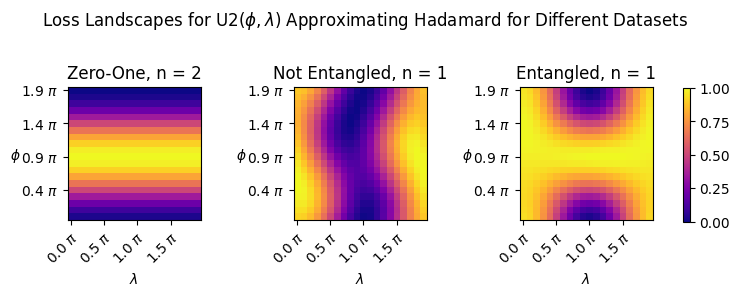

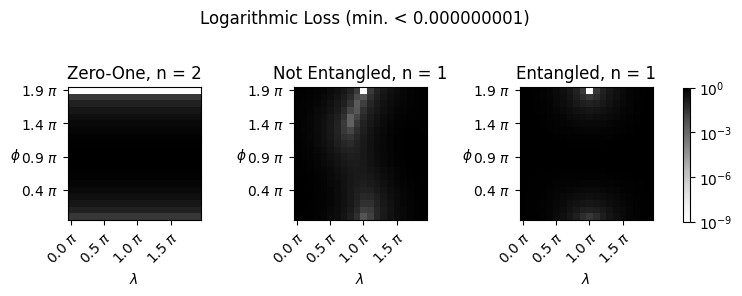

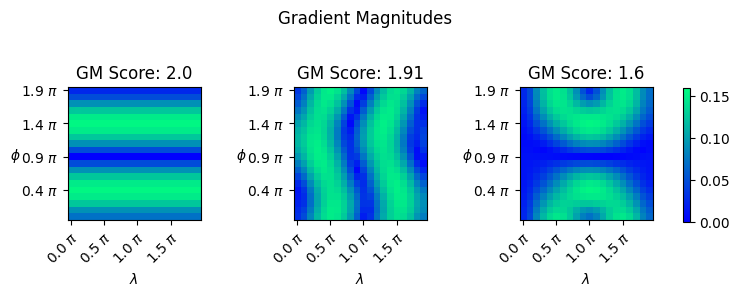

TOTAL VARIATION:  12.56 14.93 12.46
IGSD (dir 1):  9.09
IGSD (dir 2):  2.514153754497705e+16
---------
IGSD (dir 1):  28.66
IGSD (dir 2):  10.14
---------
IGSD (dir 1):  14.72
IGSD (dir 2):  15.71
---------
Frequency Domain for Plot 3
Fourier Density: 1.701


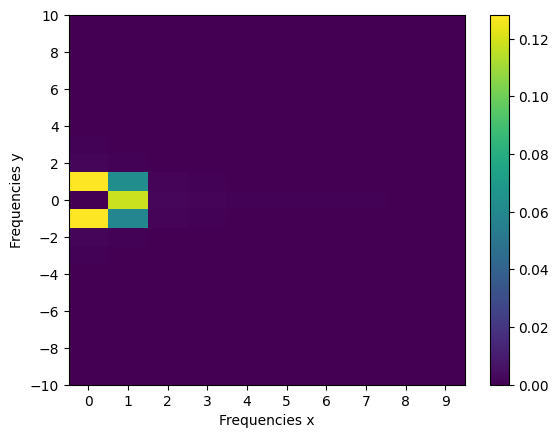

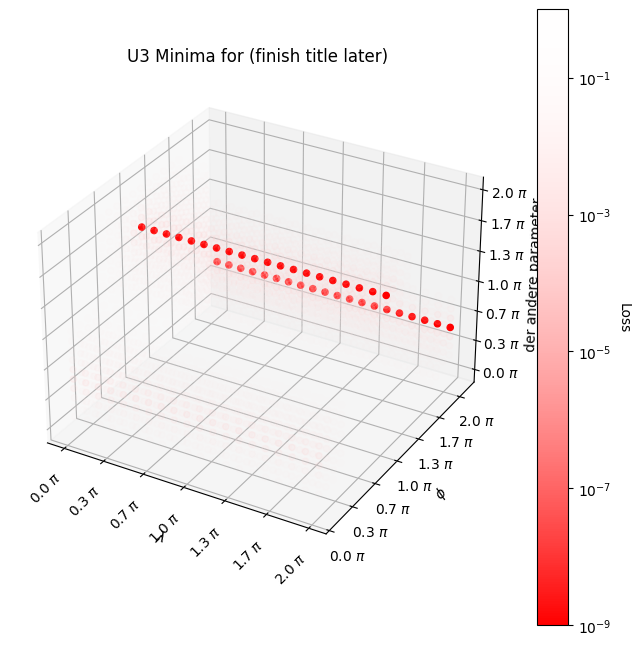

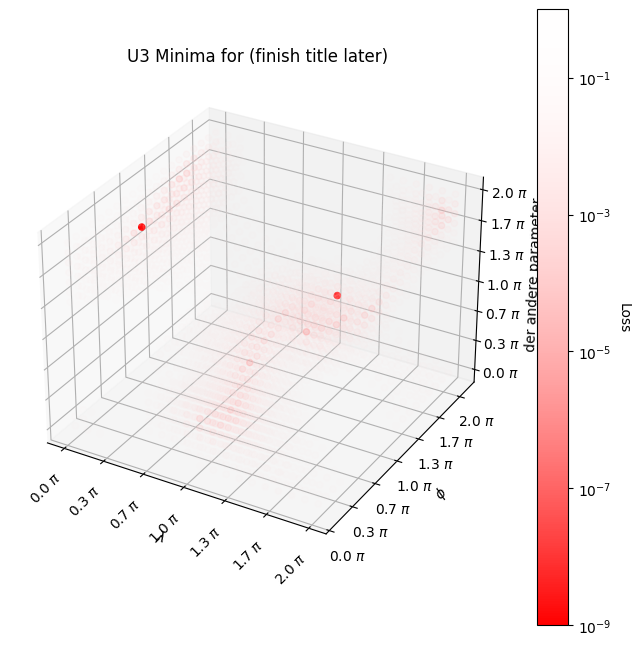

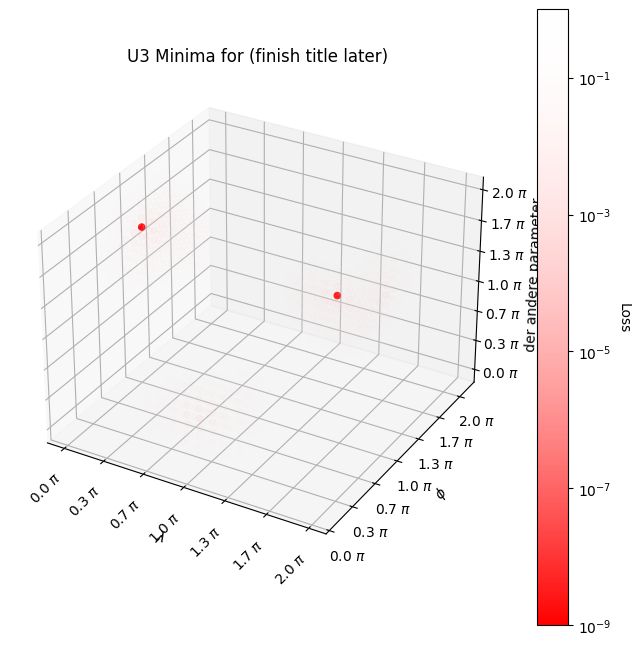

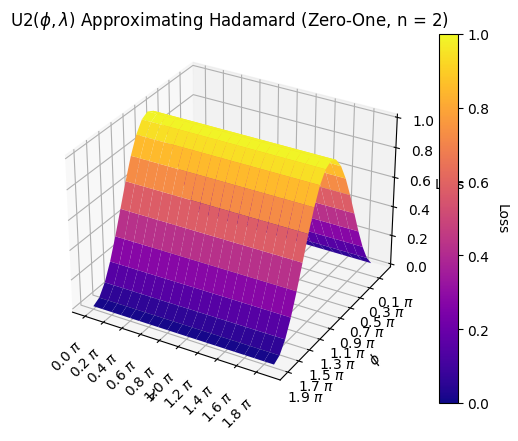

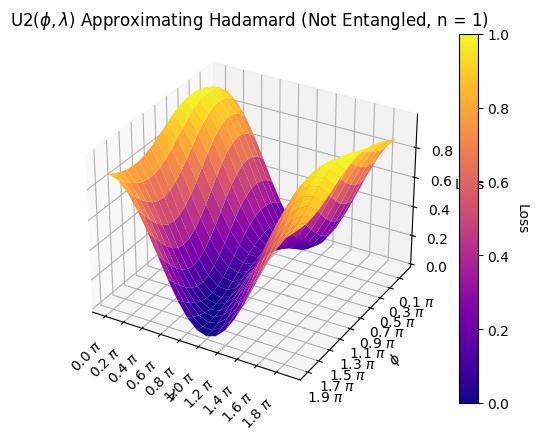

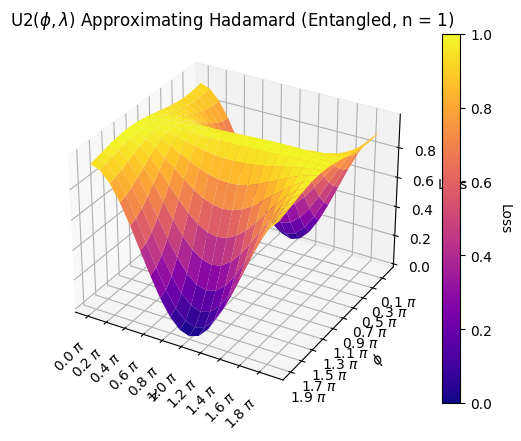

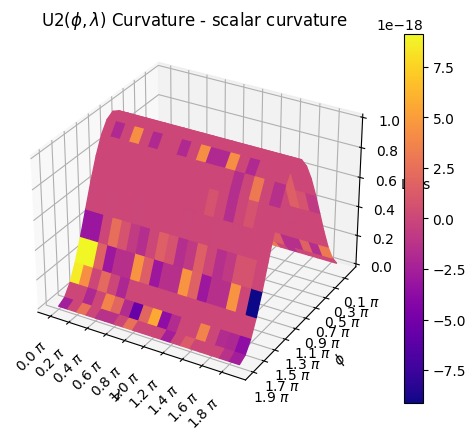

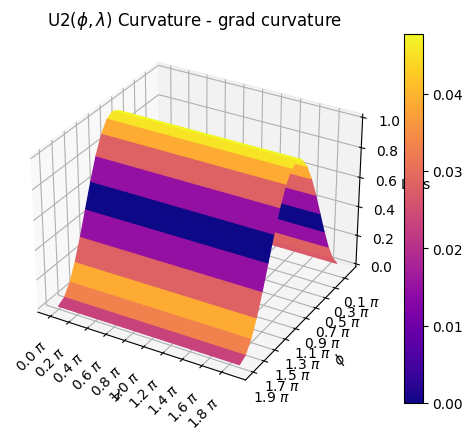

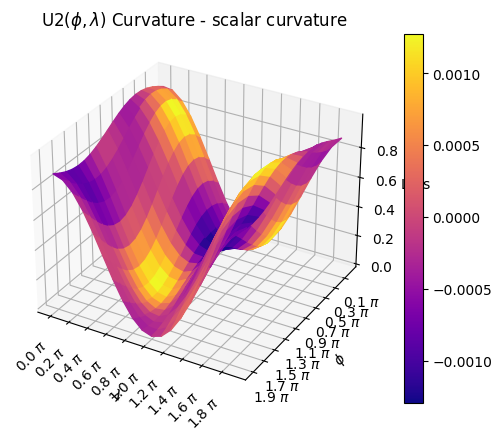

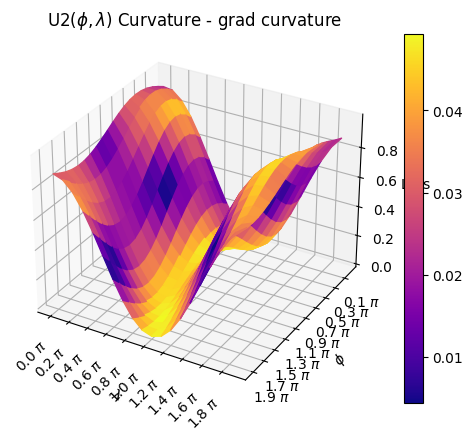

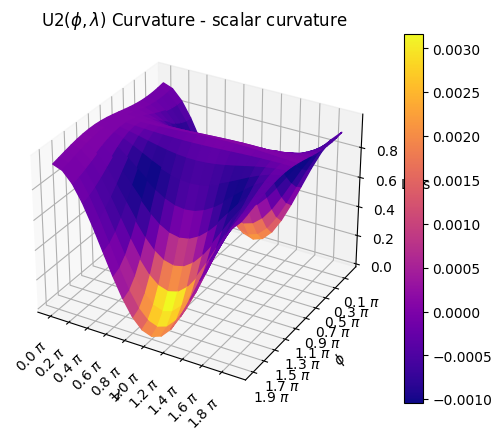

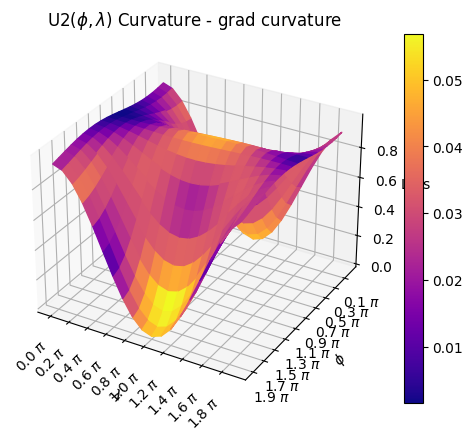

In [145]:
# EXP on Hadamard
U = torch.tensor(np.array([[1, 1], [1, -1]]) / np.sqrt(2), dtype=torch.complex128, device="cpu")
run_experiment_on("Hadamard", U, ansatz = "U2", print_info=False, num_data_points=1, num_ticks = 20, fourier_plot=3)
# U3 visualization has troubles with different tick numbers -> maybe sample errors? 
# red dots on logarithmic loss are true minima (below a certain threshold), sometimes they are just above the threshold but still true minima (due to sampling) and they will appear white (not grey, as grey means they are false minima)
# if num_ticks is too large you cant see the red dots anymore (maybe due to aliasing?)

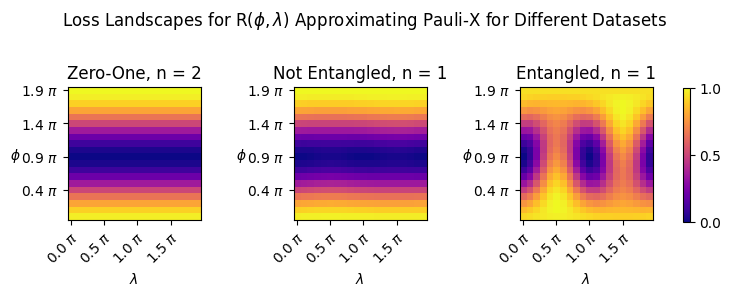

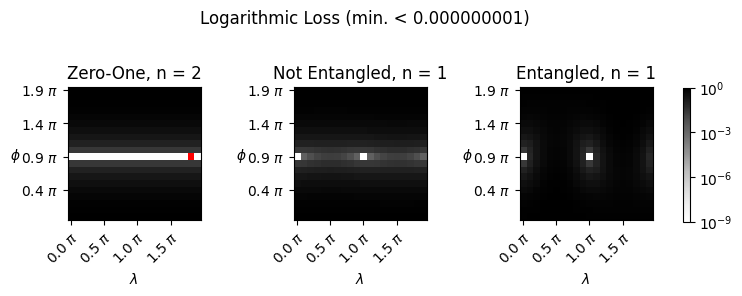

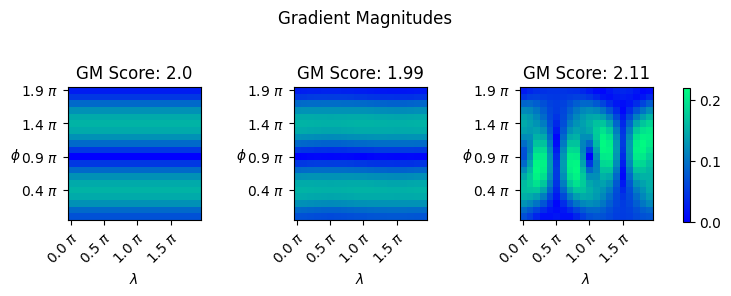

TOTAL VARIATION:  12.56 12.83 16.62
IGSD (dir 1):  9.09
IGSD (dir 2):  1.833841239060594e+16
---------
IGSD (dir 1):  9.18
IGSD (dir 2):  260.99
---------
IGSD (dir 1):  13.72
IGSD (dir 2):  10.49
---------
Frequency Domain for Plot 3
Fourier Density: 1.912


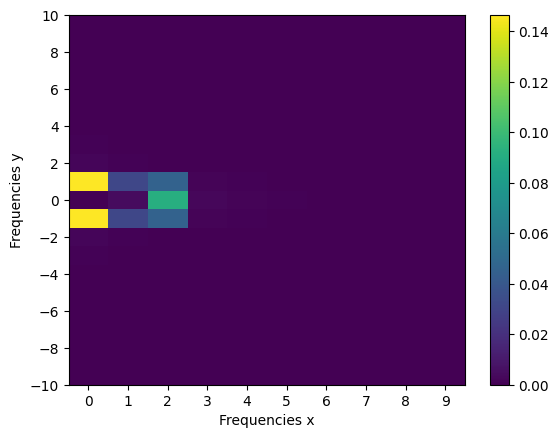

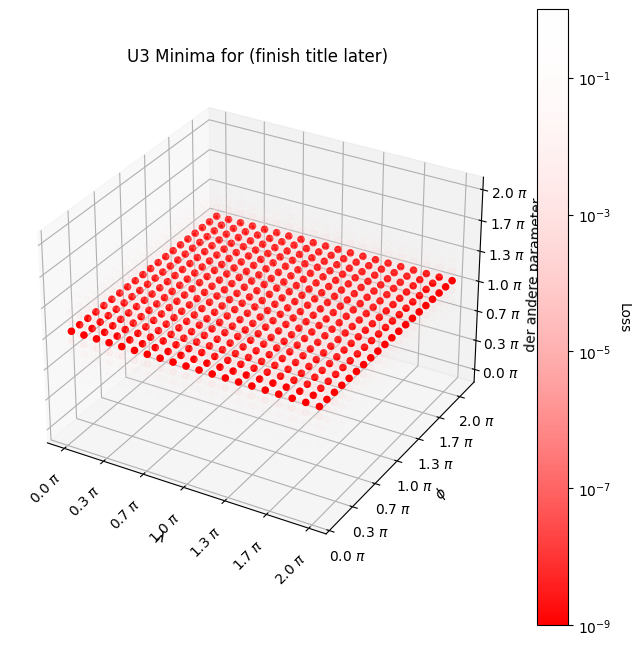

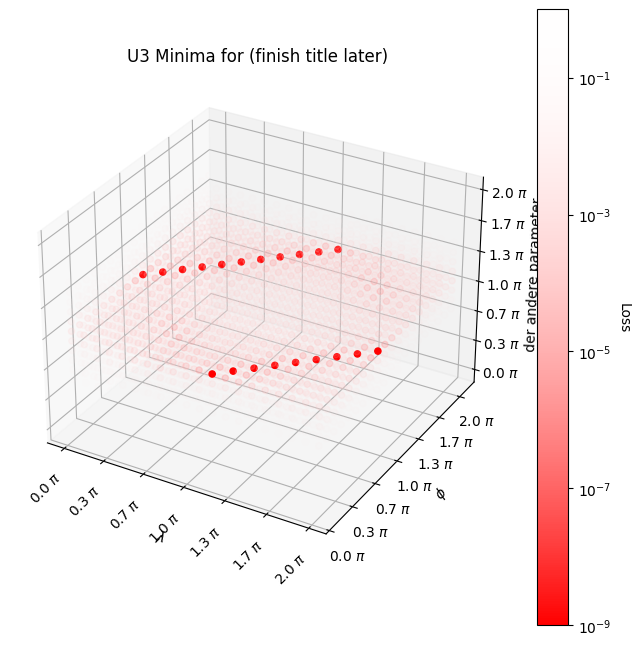

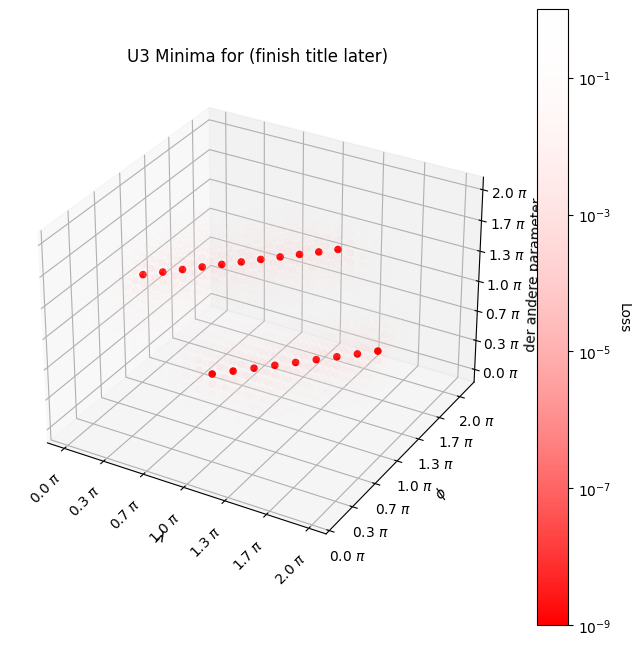

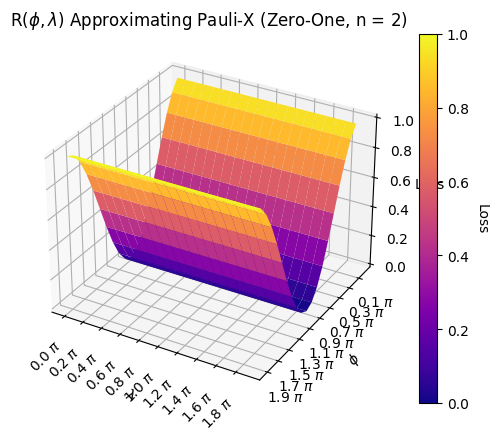

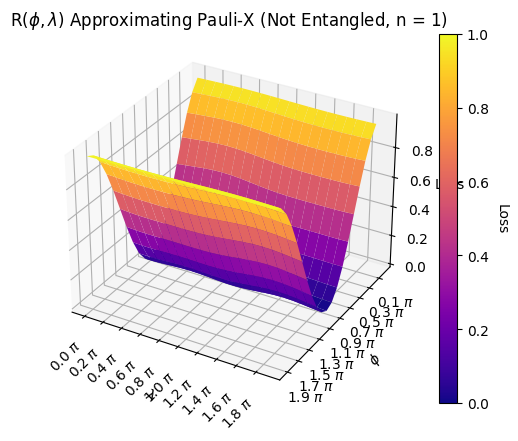

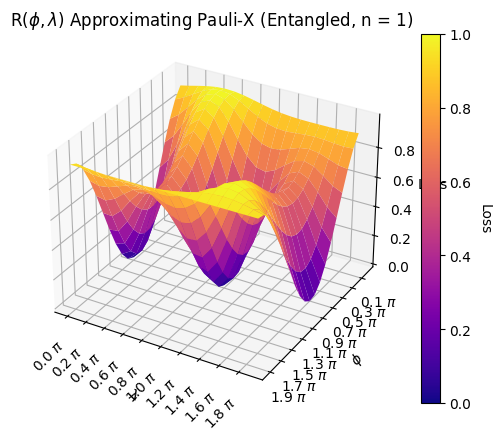

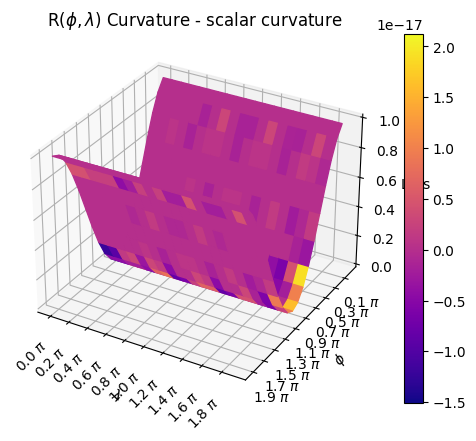

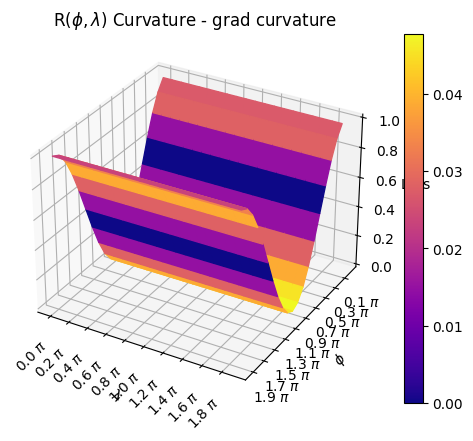

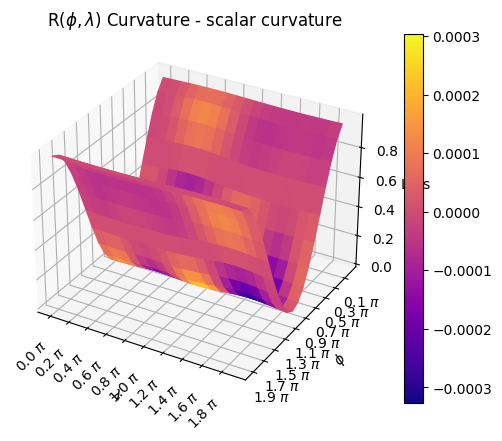

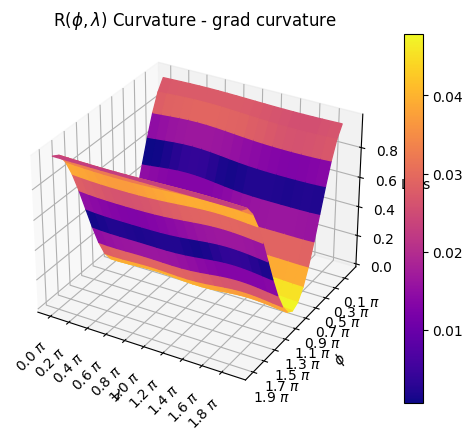

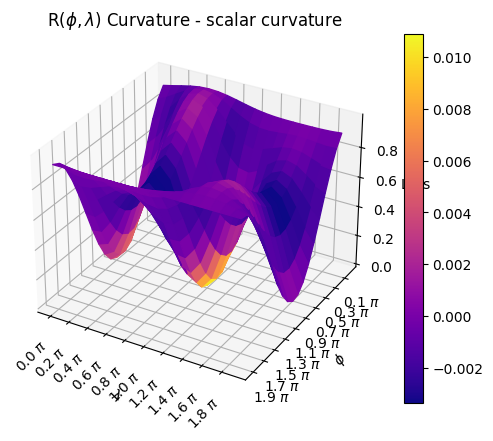

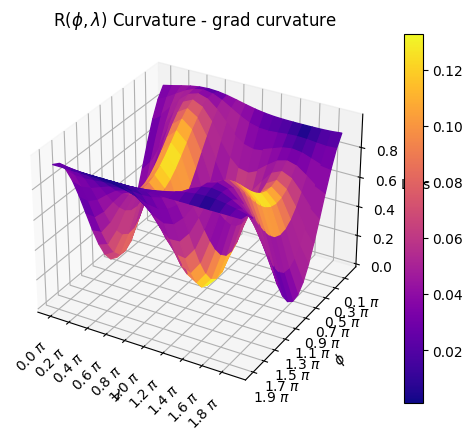

In [146]:
# EXP on Pauli-X
U = torch.tensor(np.array([[0, 1], [1, 0]]), dtype=torch.complex128, device="cpu")
run_experiment_on("Pauli-X", U, ansatz = "R", print_info=False, num_data_points=1, num_ticks = 20, fourier_plot=3)

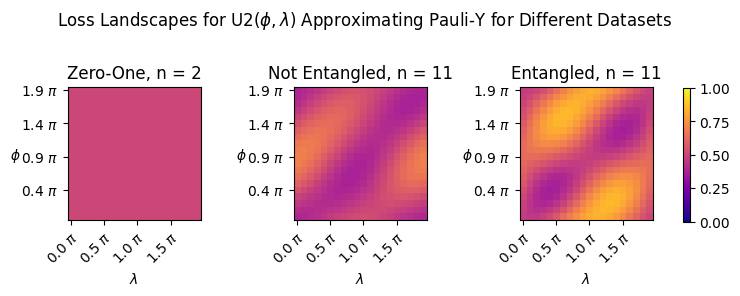

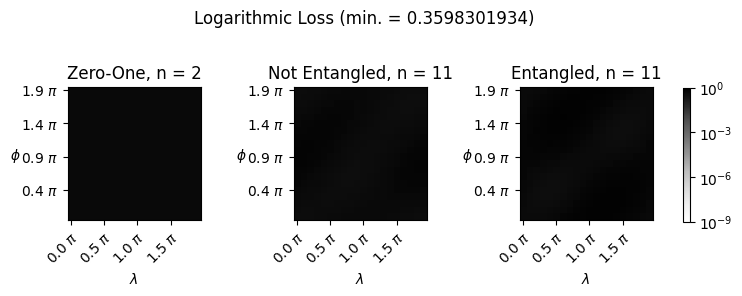

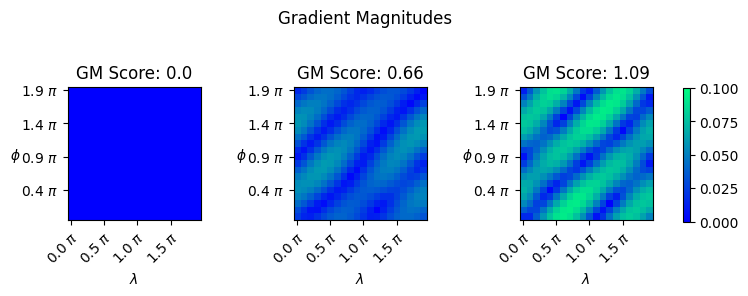

TOTAL VARIATION:  0.0 5.59 9.15
IGSD (dir 1):  2.4693626834184936e+16
IGSD (dir 2):  2.671384467238652e+16
---------
IGSD (dir 1):  38.99
IGSD (dir 2):  38.96
---------
IGSD (dir 1):  23.91
IGSD (dir 2):  23.92
---------
Frequency Domain for Plot 2
Fourier Density: 1.183


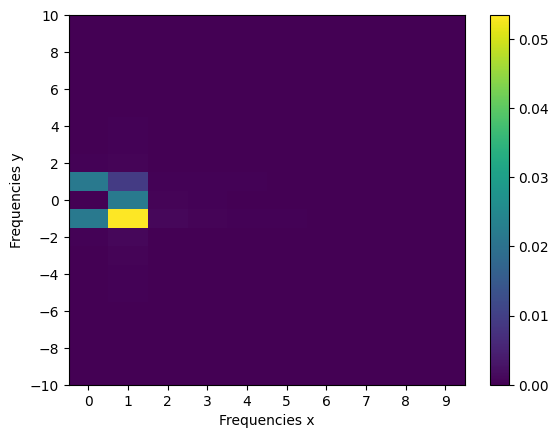

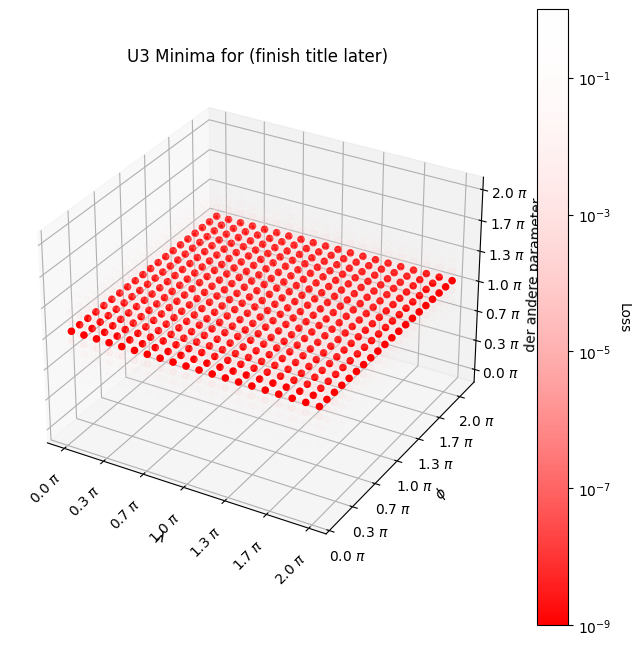

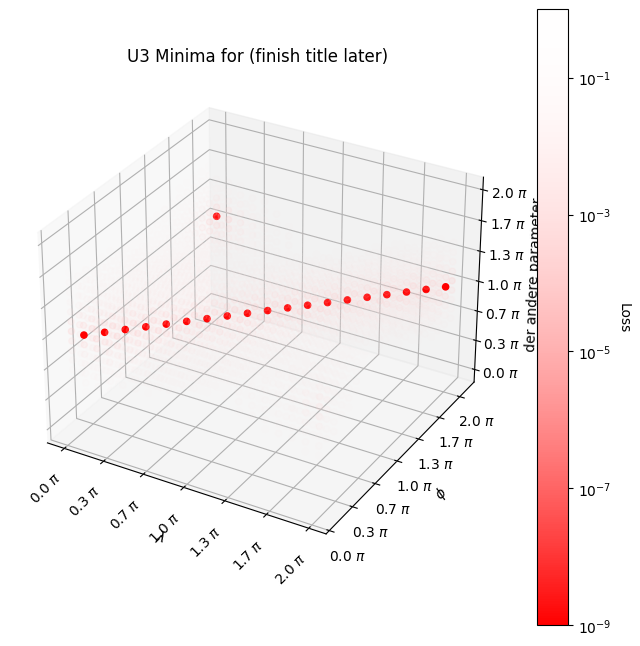

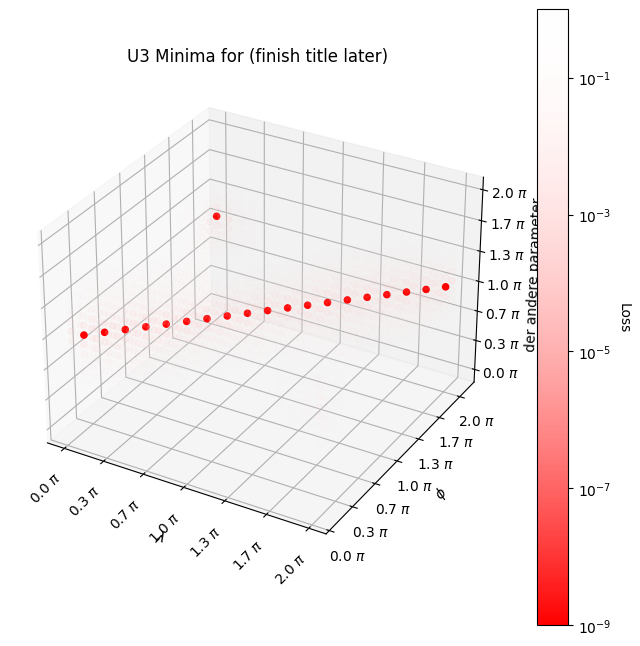

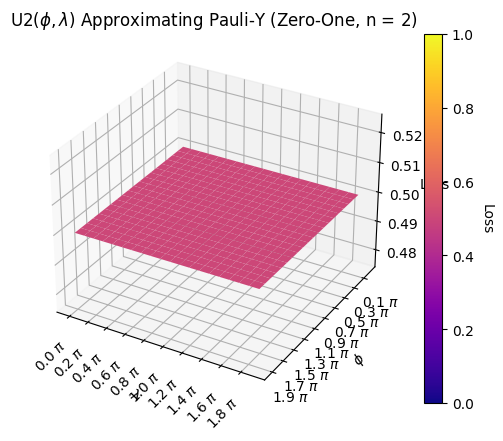

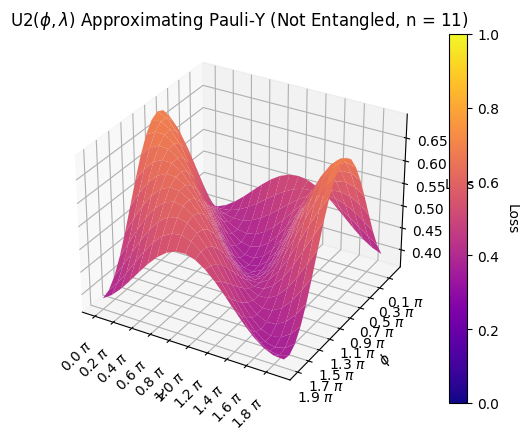

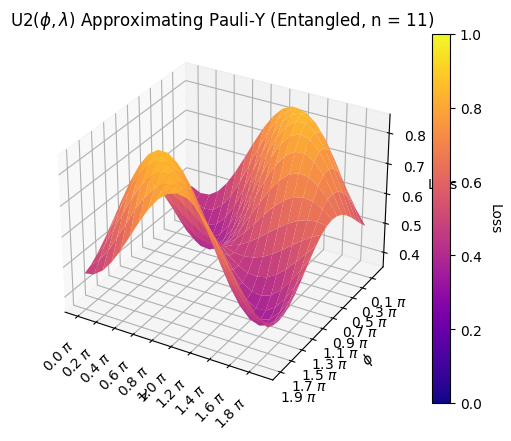

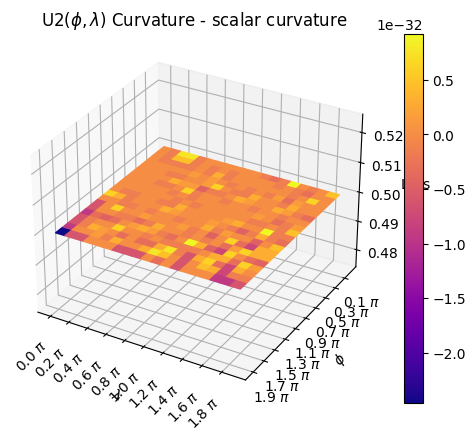

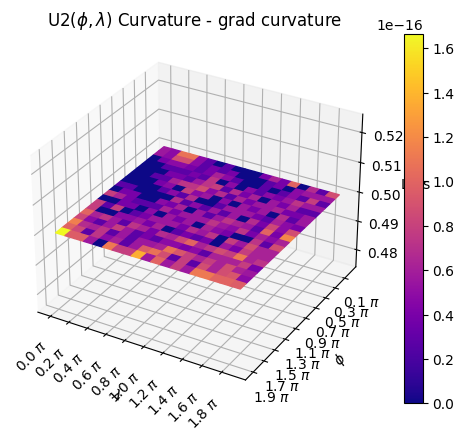

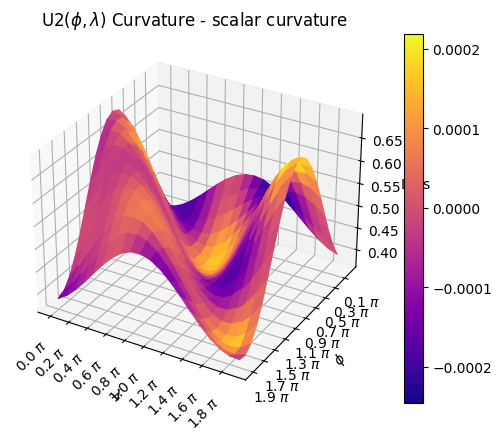

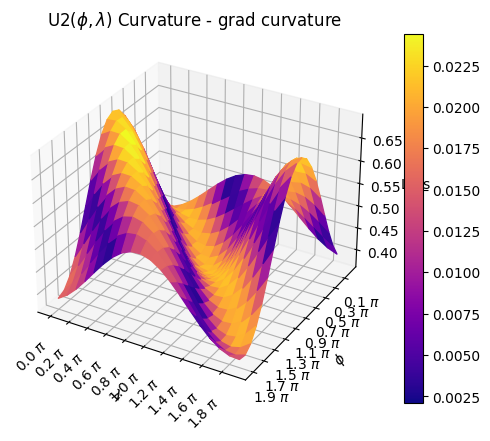

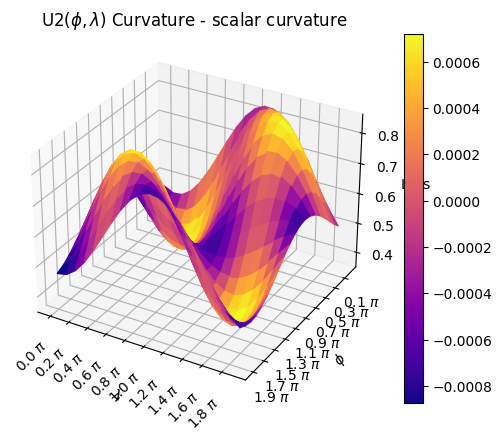

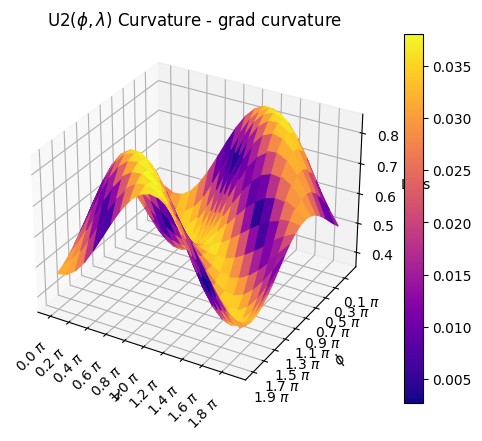

In [147]:
# EXP on Pauli-Y
U = torch.tensor(np.array([[0, -1j], [1j, 0]]), dtype=torch.complex128, device="cpu")
run_experiment_on("Pauli-Y", U, ansatz = "U2", print_info=False, num_data_points=11, num_ticks = 20, fourier_plot=2)

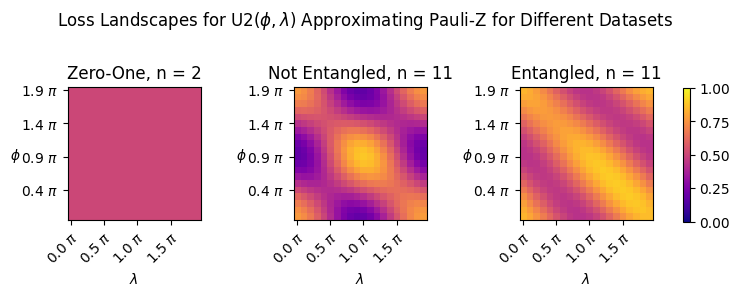

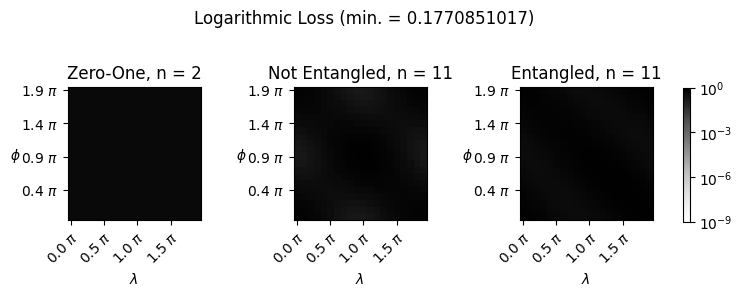

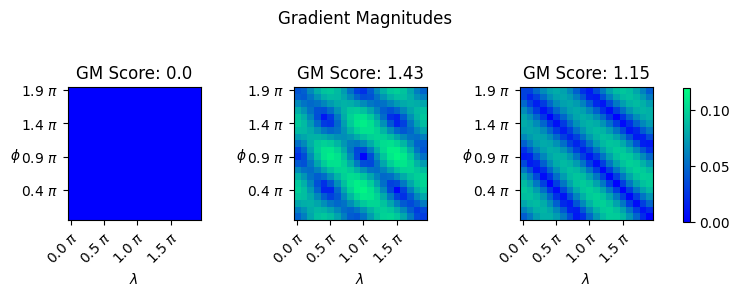

TOTAL VARIATION:  0.0 11.38 10.09
IGSD (dir 1):  1.6798695823161282e+16
IGSD (dir 2):  1.6798695823161282e+16
---------
IGSD (dir 1):  18.78
IGSD (dir 2):  18.78
---------
IGSD (dir 1):  22.27
IGSD (dir 2):  22.27
---------
Frequency Domain for Plot 3
Fourier Density: 1.12


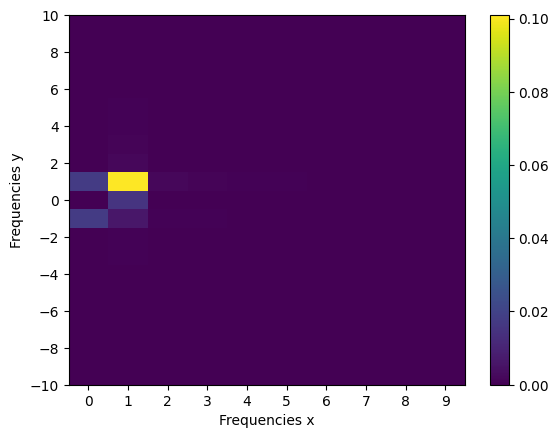

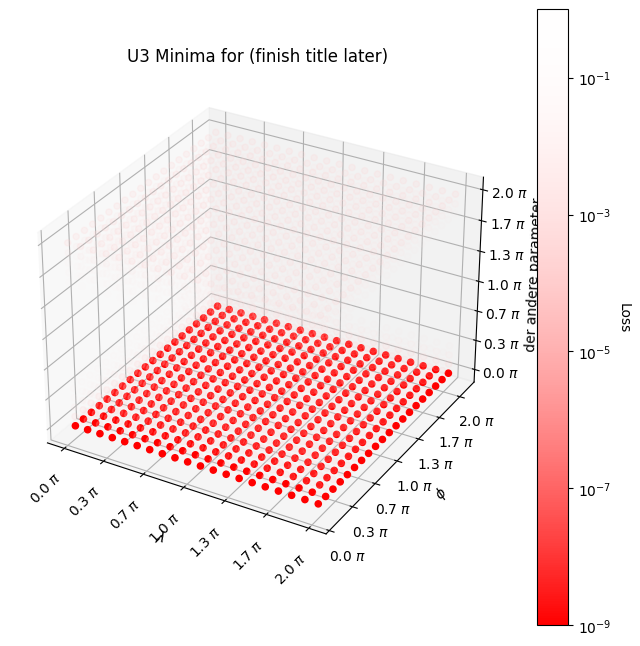

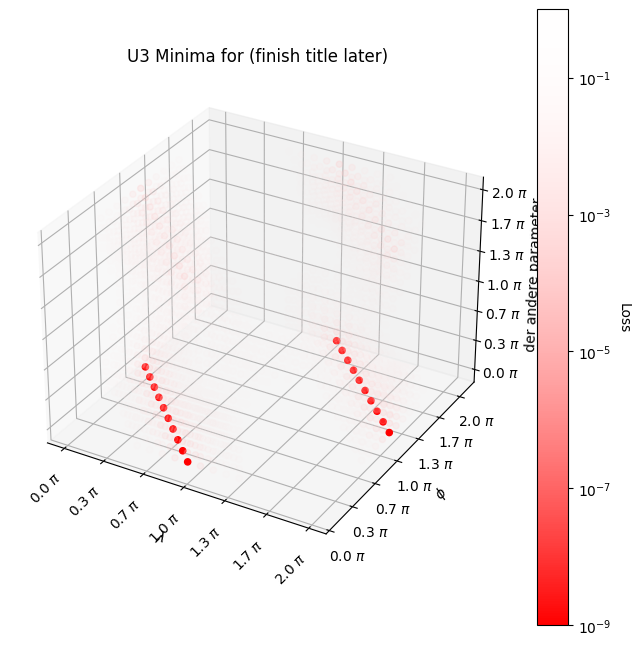

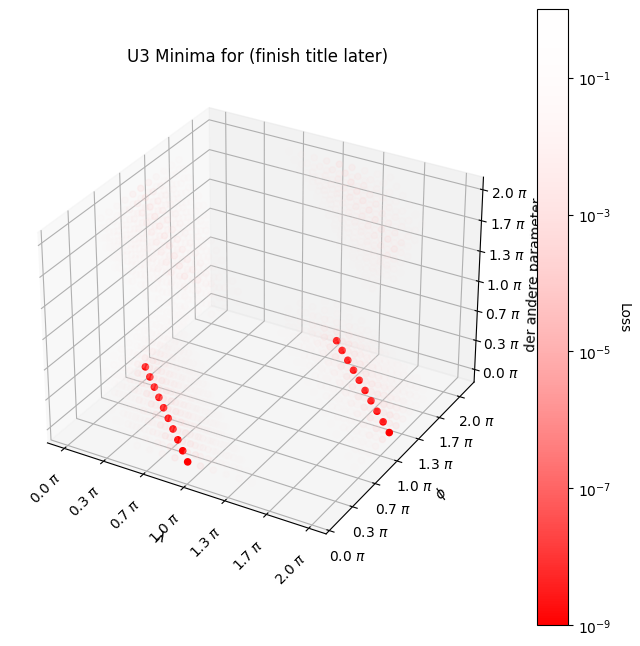

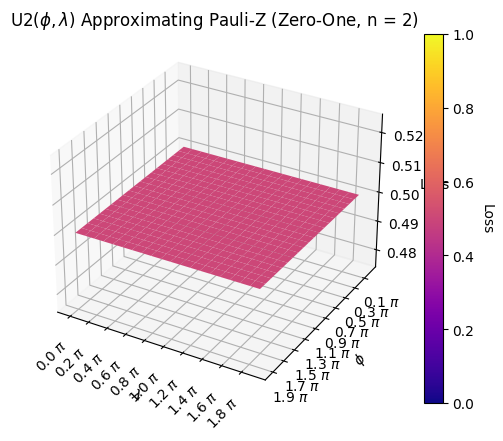

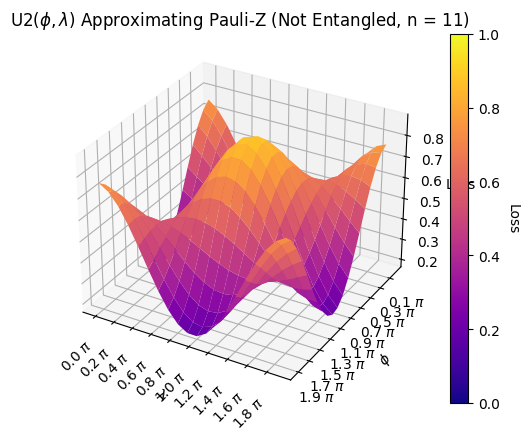

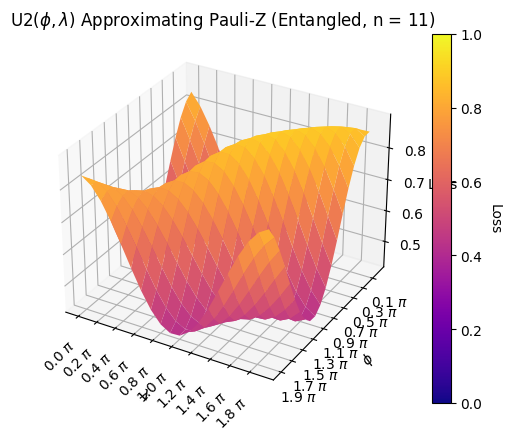

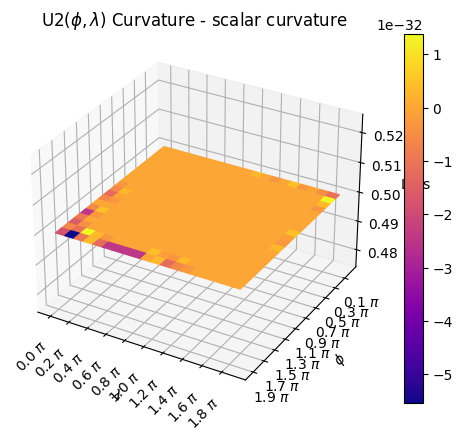

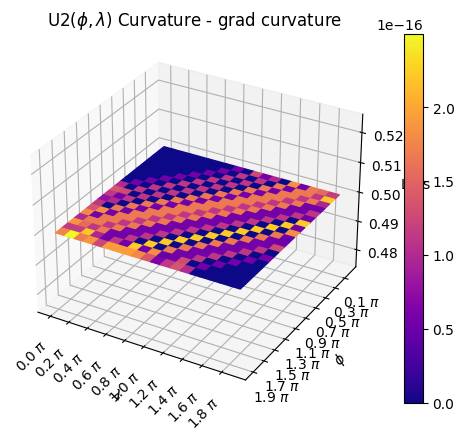

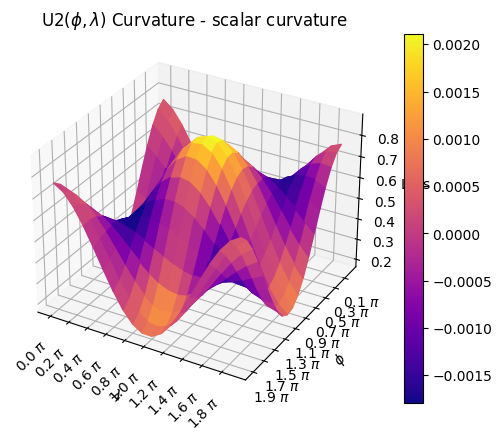

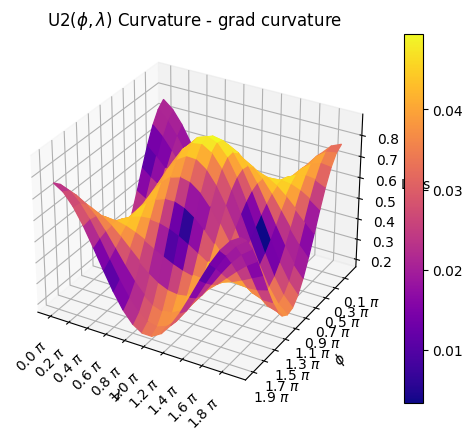

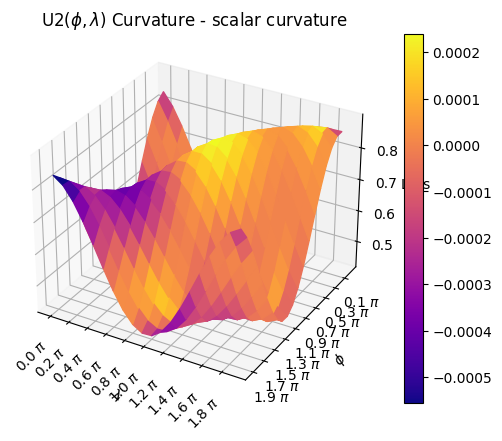

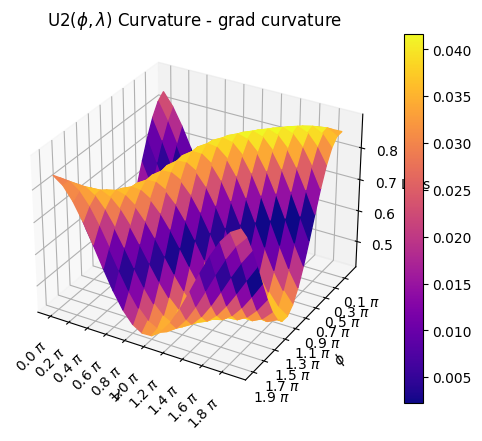

In [148]:
# EXP on Pauli-Z
U = torch.tensor(np.array([[1, 0], [0, -1]]), dtype=torch.complex128, device="cpu")
run_experiment_on("Pauli-Z", U, ansatz = "U2", print_info=False, num_data_points=11, num_ticks = 20, fourier_plot=3)

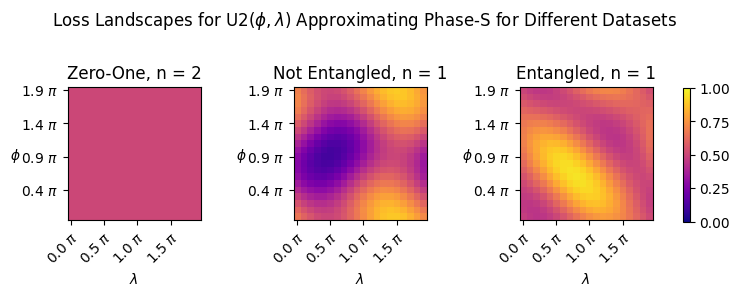

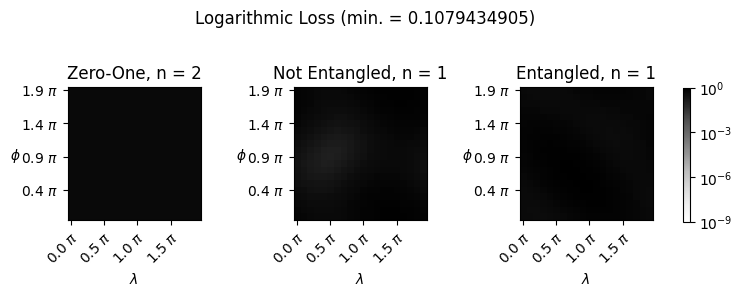

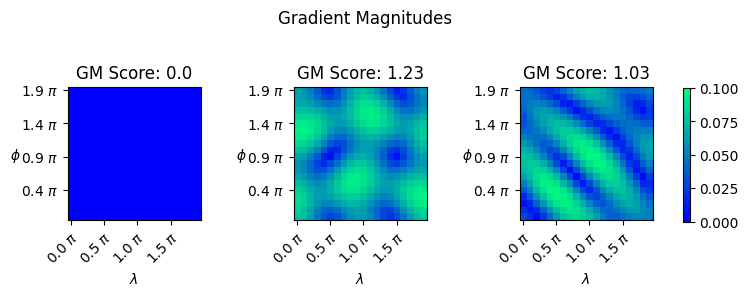

TOTAL VARIATION:  0.0 10.28 8.55
IGSD (dir 1):  1.6210122135334168e+16
IGSD (dir 2):  1.6210122135334168e+16
---------
IGSD (dir 1):  21.9
IGSD (dir 2):  22.11
---------
IGSD (dir 1):  25.06
IGSD (dir 2):  25.06
---------
Frequency Domain for Plot 1
Fourier Density: 1.0


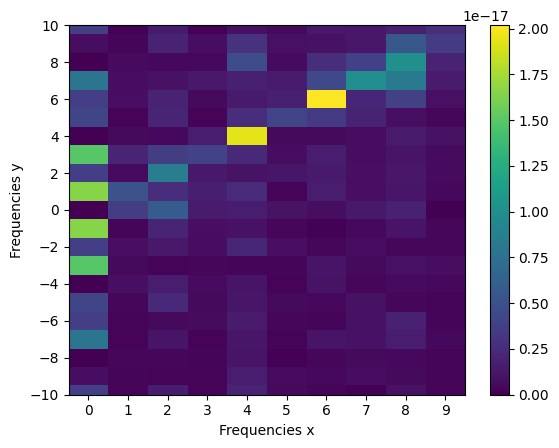

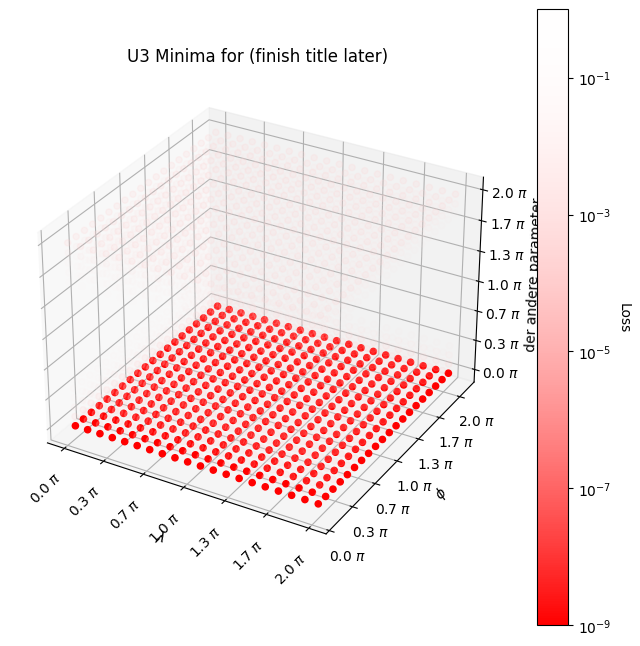

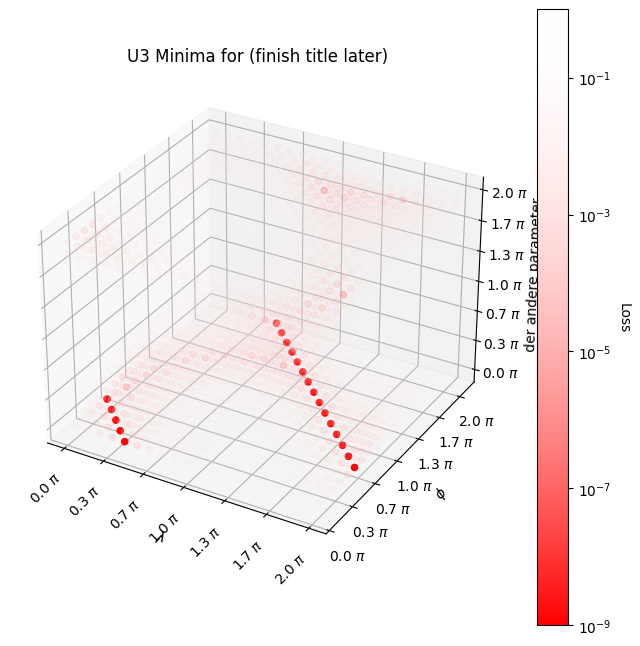

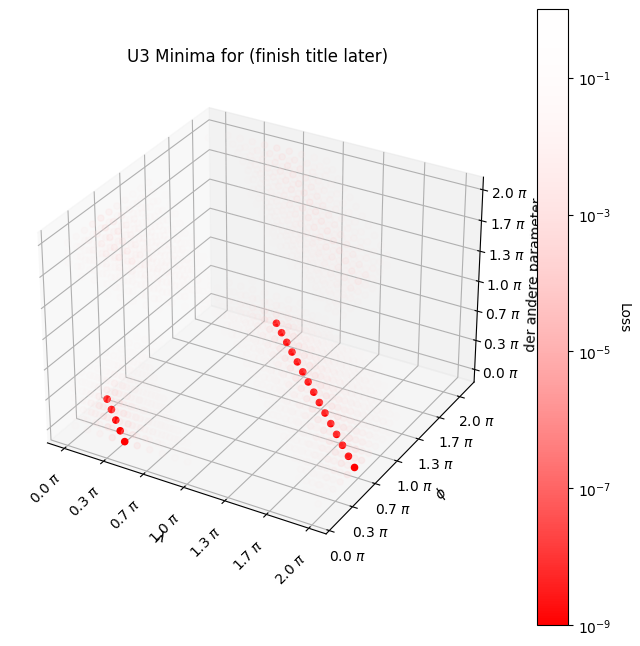

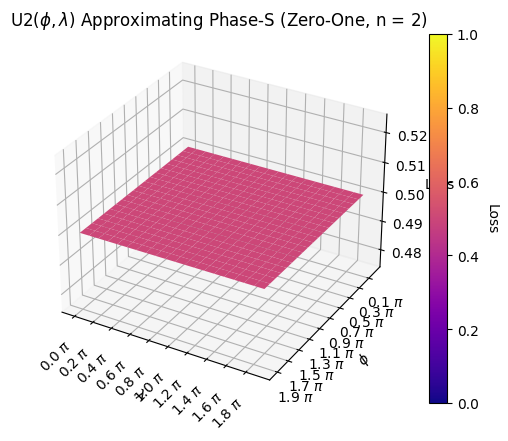

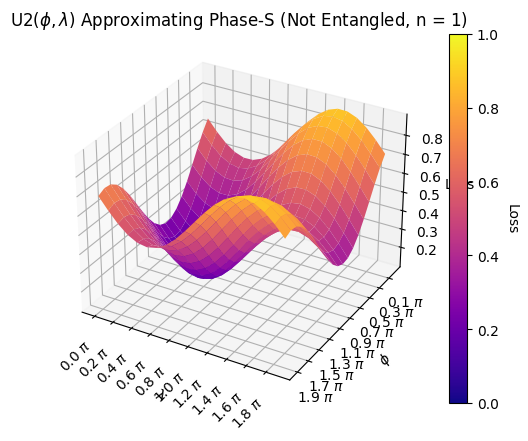

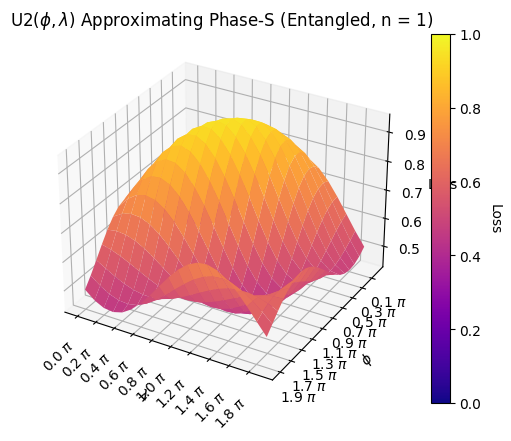

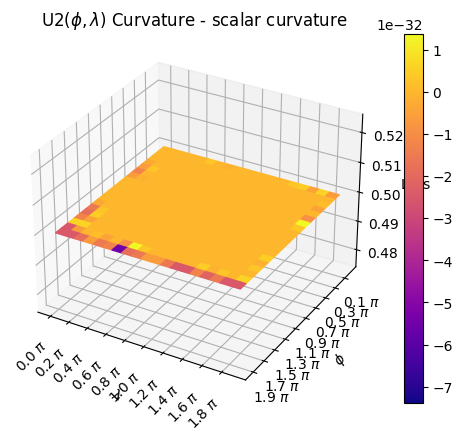

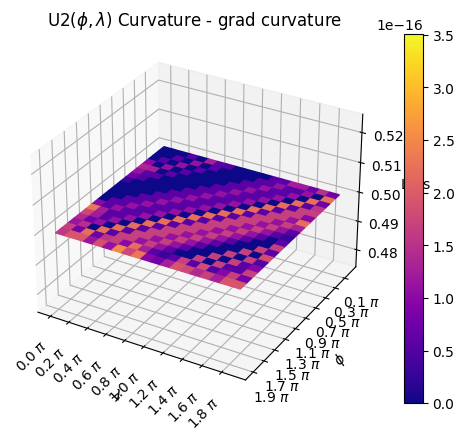

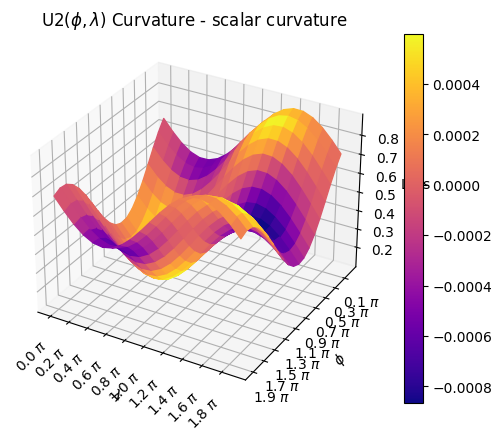

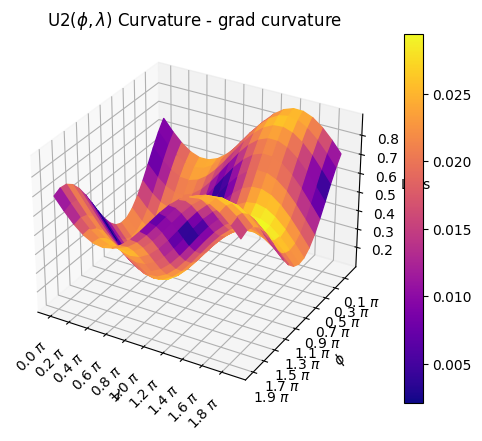

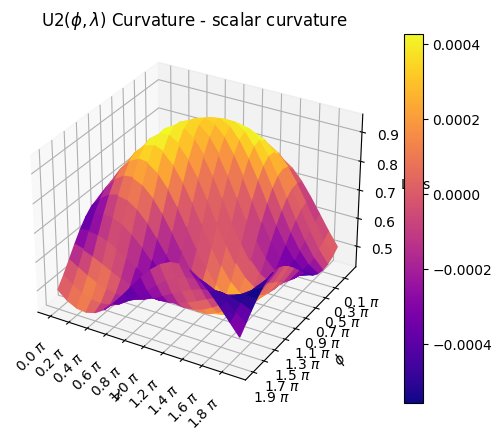

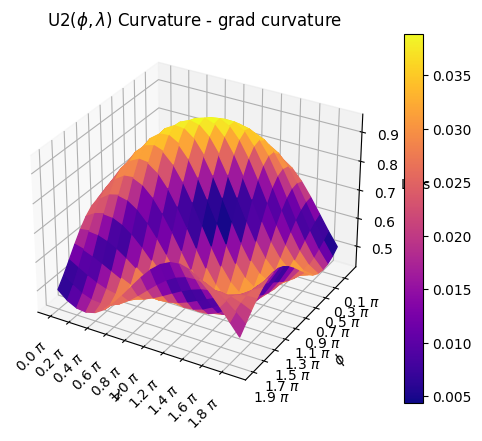

In [149]:
# EXP on Phase (S)
U = torch.tensor(np.array([[1, 0], [0, 1j]]), dtype=torch.complex128, device="cpu")
run_experiment_on("Phase-S", U, ansatz = "U2", print_info=False, num_data_points=1, num_ticks = 20, fourier_plot=1)